In [1]:
import numpy as np
from math import log10
import math
import matplotlib.pyplot as plt
import os
import sys
from os import listdir
from os.path import join, isdir
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import cupy
import re
from torchvision.utils import save_image as imwrite

In [2]:
# parameters
args = {
    'train': './db',
    'kernel': 51,
    'out_dir': './output_sepconv_pytorch',
    'epochs': 10,
    'batch_size': 4,
    'load_model': None,
    'test_input': './Interpolation_testset/input',
    'gt': './Interpolation_testset/gt',
}
modelType = 'lf'
modelPath = os.path.join(os.getcwd(), 'network-' + modelType + '.pytorch')
input_dir = os.path.join(os.getcwd(), 'my_testset')
output_dir = os.path.join(os.getcwd(), 'my_output')
# checkpoint_dir = os.path.join(os.getcwd(), 'output_sepconv_pytorch', 'checkpoint', 'model_epoch010.pth')

# Model

In [3]:
def to_variable(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

class KernelEstimation(torch.nn.Module):
    def __init__(self, kernel_size):
        super(KernelEstimation, self).__init__()
        self.kernel_size = kernel_size

        def Basic(input_channel, output_channel):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )

        def Upsample(channel):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False)
            )

        def Subnet(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                torch.nn.Conv2d(in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1)
            )

        self.moduleConv1 = Basic(6, 32)
        self.modulePool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv2 = Basic(32, 64)
        self.modulePool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv3 = Basic(64, 128)
        self.modulePool3 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv4 = Basic(128, 256)
        self.modulePool4 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleConv5 = Basic(256, 512)
        self.modulePool5 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.moduleDeconv5 = Basic(512, 512)
        self.moduleUpsample5 = Upsample(512)

        self.moduleDeconv4 = Basic(512, 256)
        self.moduleUpsample4 = Upsample(256)

        self.moduleDeconv3 = Basic(256, 128)
        self.moduleUpsample3 = Upsample(128)

        self.moduleDeconv2 = Basic(128, 64)
        self.moduleUpsample2 = Upsample(64)

        self.moduleVertical1 = Subnet(self.kernel_size)
        self.moduleVertical2 = Subnet(self.kernel_size)
        self.moduleHorizontal1 = Subnet(self.kernel_size)
        self.moduleHorizontal2 = Subnet(self.kernel_size)

        # use this line only when testing on pretrained model. Comment it out when training
        self.load_state_dict(torch.load(modelPath))

    def forward(self, rfield0, rfield2):
        tensorJoin = torch.cat([rfield0, rfield2], 1)

        tensorConv1 = self.moduleConv1(tensorJoin)
        tensorPool1 = self.modulePool1(tensorConv1)

        tensorConv2 = self.moduleConv2(tensorPool1)
        tensorPool2 = self.modulePool2(tensorConv2)

        tensorConv3 = self.moduleConv3(tensorPool2)
        tensorPool3 = self.modulePool3(tensorConv3)

        tensorConv4 = self.moduleConv4(tensorPool3)
        tensorPool4 = self.modulePool4(tensorConv4)

        tensorConv5 = self.moduleConv5(tensorPool4)
        tensorPool5 = self.modulePool5(tensorConv5)

        tensorDeconv5 = self.moduleDeconv5(tensorPool5)
        tensorUpsample5 = self.moduleUpsample5(tensorDeconv5)

        tensorCombine = tensorUpsample5 + tensorConv5

        tensorDeconv4 = self.moduleDeconv4(tensorCombine)
        tensorUpsample4 = self.moduleUpsample4(tensorDeconv4)

        tensorCombine = tensorUpsample4 + tensorConv4

        tensorDeconv3 = self.moduleDeconv3(tensorCombine)
        tensorUpsample3 = self.moduleUpsample3(tensorDeconv3)

        tensorCombine = tensorUpsample3 + tensorConv3

        tensorDeconv2 = self.moduleDeconv2(tensorCombine)
        tensorUpsample2 = self.moduleUpsample2(tensorDeconv2)

        tensorCombine = tensorUpsample2 + tensorConv2

        Vertical1 = self.moduleVertical1(tensorCombine)
        Vertical2 = self.moduleVertical2(tensorCombine)
        Horizontal1 = self.moduleHorizontal1(tensorCombine)
        Horizontal2 = self.moduleHorizontal2(tensorCombine)

        return Vertical1, Horizontal1, Vertical2, Horizontal2

kernel_Sepconv_updateOutput = '''
    extern "C" __global__ void kernel_Sepconv_updateOutput(
        const int n,
        const float* input,
        const float* vertical,
        const float* horizontal,
        float* output
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float dblOutput = 0.0;

        const int intSample = ( intIndex / SIZE_3(output) / SIZE_2(output) / SIZE_1(output) ) % SIZE_0(output);
        const int intDepth  = ( intIndex / SIZE_3(output) / SIZE_2(output)                  ) % SIZE_1(output);
        const int intY      = ( intIndex / SIZE_3(output)                                   ) % SIZE_2(output);
        const int intX      = ( intIndex                                                    ) % SIZE_3(output);

        for (int intFilterY = 0; intFilterY < SIZE_1(vertical); intFilterY += 1) {
        for (int intFilterX = 0; intFilterX < SIZE_1(horizontal); intFilterX += 1) {
        dblOutput += VALUE_4(input, intSample, intDepth, intY + intFilterY, intX + intFilterX) * VALUE_4(vertical, intSample, intFilterY, intY, intX) * VALUE_4(horizontal, intSample, intFilterX, intY, intX);
            }
        }

        output[intIndex] = dblOutput;
    } }
'''

kernel_SeparableConvolution_updateGradVertical = '''
    extern "C" __global__ void kernel_SeparableConvolution_updateGradVertical(
        const int n,
        const float* gradLoss,
        const float* input,
        const float* horizontal,
        float* gradVertical
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float floatOutput = 0.0;
        float c = 0.0;
    
        const int intBatch   = ( intIndex / SIZE_3(gradVertical) / SIZE_2(gradVertical) / SIZE_1(gradVertical) ) % SIZE_0(gradVertical);
        const int intFilterY = ( intIndex / SIZE_3(gradVertical) / SIZE_2(gradVertical)                        ) % SIZE_1(gradVertical);
        const int intY       = ( intIndex / SIZE_3(gradVertical)                                               ) % SIZE_2(gradVertical);
        const int intX       = ( intIndex                                                                      ) % SIZE_3(gradVertical);
    
        for (int intFilterX = 0; intFilterX < SIZE_1(horizontal); intFilterX++) 
        {
            float product = VALUE_4(gradLoss, intBatch, 0, intY, intX)*              // channel 0
            VALUE_4(input, intBatch, 0, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX) +
            VALUE_4(gradLoss, intBatch, 1, intY, intX)*                          // channel 1     
            VALUE_4(input, intBatch, 1, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX) +
            VALUE_4(gradLoss, intBatch, 2, intY, intX)*                          // channel 2
            VALUE_4(input, intBatch, 2, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(horizontal, intBatch, intFilterX, intY, intX);

            floatOutput += product;
        }
    
        gradVertical[intIndex] = floatOutput;
    } }
'''

kernel_SeparableConvolution_updateGradHorizontal = '''
    extern "C" __global__ void kernel_SeparableConvolution_updateGradHorizontal(
        const int n,
        const float* gradLoss,
        const float* input,
        const float* vertical,
        float* gradHorizontal
    ) { for (int intIndex = (blockIdx.x * blockDim.x) + threadIdx.x; intIndex < n; intIndex += blockDim.x * gridDim.x) {
        float floatOutput = 0.0;
        float c = 0.0;
    
        const int intBatch   = ( intIndex / SIZE_3(gradHorizontal) / SIZE_2(gradHorizontal) / SIZE_1(gradHorizontal) ) % SIZE_0(gradHorizontal);
        const int intFilterX = ( intIndex / SIZE_3(gradHorizontal) / SIZE_2(gradHorizontal)                          ) % SIZE_1(gradHorizontal);
        const int intY       = ( intIndex / SIZE_3(gradHorizontal)                                                   ) % SIZE_2(gradHorizontal);
        const int intX       = ( intIndex                                                                            ) % SIZE_3(gradHorizontal);
    
        for (int intFilterY = 0; intFilterY < SIZE_1(vertical); intFilterY++)
        {
            float product = VALUE_4(gradLoss, intBatch, 0, intY, intX)*             // channel 0
            VALUE_4(input, intBatch, 0, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX) + 
            VALUE_4(gradLoss, intBatch, 1, intY, intX)*                         // channel 1
            VALUE_4(input, intBatch, 1, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX) + 
            VALUE_4(gradLoss, intBatch, 2, intY, intX)*                         // channel 2
            VALUE_4(input, intBatch, 2, intY + intFilterY, intX + intFilterX)* 
            VALUE_4(vertical, intBatch, intFilterY, intY, intX);
    
            float y = product - c;
            float t = floatOutput + y;
            c = (t - floatOutput) - y;
            floatOutput = t;
        }
    
        gradHorizontal[intIndex] = floatOutput;
    } }
'''

def cupy_kernel(strFunction, objectVariables):
    strKernel = globals()[strFunction]

    while True:
        objectMatch = re.search('(SIZE_)([0-4])(\()([^\)]*)(\))', strKernel)

        if objectMatch is None:
            break
        # end

        intArg = int(objectMatch.group(2))

        strTensor = objectMatch.group(4)
        intSizes = objectVariables[strTensor].size()

        strKernel = strKernel.replace(objectMatch.group(), str(intSizes[intArg]))
    # end

    while True:
        objectMatch = re.search('(VALUE_)([0-4])(\()([^\)]+)(\))', strKernel)

        if objectMatch is None:
            break
        # end

        intArgs = int(objectMatch.group(2))
        strArgs = objectMatch.group(4).split(',')

        strTensor = strArgs[0]
        intStrides = objectVariables[strTensor].stride()
        strIndex = ['((' + strArgs[intArg + 1].replace('{', '(').replace('}', ')').strip() + ')*' + str(intStrides[intArg]) + ')' for intArg in range(intArgs)]

        strKernel = strKernel.replace(objectMatch.group(0), strTensor + '[' + str.join('+', strIndex) + ']')
    # end

    return strKernel


@cupy.util.memoize(for_each_device=True)
def cupy_launch(strFunction, strKernel):
    return cupy.cuda.compile_with_cache(strKernel).get_function(strFunction)


class FunctionSepconv(torch.autograd.Function):
    def __init__(self):
        super(FunctionSepconv, self).__init__()

    # end

    def forward(self, input, vertical, horizontal):
        self.save_for_backward(input, vertical, horizontal)

        intSample = input.size(0)
        intInputDepth = input.size(1)
        intInputHeight = input.size(2)
        intInputWidth = input.size(3)
        intFilterSize = min(vertical.size(1), horizontal.size(1))
        intOutputHeight = min(vertical.size(2), horizontal.size(2))
        intOutputWidth = min(vertical.size(3), horizontal.size(3))

        assert (intInputHeight - intFilterSize == intOutputHeight - 1)
        assert (intInputWidth - intFilterSize == intOutputWidth - 1)

        assert (input.is_contiguous() == True)
        assert (vertical.is_contiguous() == True)
        assert (horizontal.is_contiguous() == True)

        output = input.new_zeros(intSample, intInputDepth, intOutputHeight, intOutputWidth)

        if input.is_cuda == True:
            class Stream:
                ptr = torch.cuda.current_stream().cuda_stream

            # end

            n = output.nelement()
            cupy_launch('kernel_Sepconv_updateOutput', cupy_kernel('kernel_Sepconv_updateOutput', {
                'input': input,
                'vertical': vertical,
                'horizontal': horizontal,
                'output': output
            }))(
                grid=tuple([int((n + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n, input.data_ptr(), vertical.data_ptr(), horizontal.data_ptr(), output.data_ptr()],
                stream=Stream
            )

        elif input.is_cuda == False:
            raise NotImplementedError()

        # end

        return output

    # end

    def backward(self, gradOutput):
        input, vertical, horizontal = self.saved_tensors

        intSample = input.size(0)
        intInputDepth = input.size(1)
        intInputHeight = input.size(2)
        intInputWidth = input.size(3)
        intFilterSize = min(vertical.size(1), horizontal.size(1))
        intOutputHeight = min(vertical.size(2), horizontal.size(2))
        intOutputWidth = min(vertical.size(3), horizontal.size(3))

        assert (intInputHeight - intFilterSize == intOutputHeight - 1)
        assert (intInputWidth - intFilterSize == intOutputWidth - 1)

        assert (gradOutput.is_contiguous() == True)

        gradInput = input.new_zeros(intSample, intInputDepth, intInputHeight, intInputWidth) if self.needs_input_grad[0] == True else None
        gradVertical = input.new_zeros(intSample, intFilterSize, intOutputHeight, intOutputWidth) if self.needs_input_grad[1] == True else None
        gradHorizontal = input.new_zeros(intSample, intFilterSize, intOutputHeight, intOutputWidth) if self.needs_input_grad[2] == True else None

        if input.is_cuda == True:
            class Stream:
                ptr = torch.cuda.current_stream().cuda_stream

            # end

            # vertical grad
            n_v = gradVertical.nelement()
            cupy_launch('kernel_SeparableConvolution_updateGradVertical', cupy_kernel('kernel_SeparableConvolution_updateGradVertical', {
                'gradLoss': gradOutput,
                'input': input,
                'horizontal': horizontal,
                'gradVertical': gradVertical
            }))(
                grid=tuple([int((n_v + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n_v, gradOutput.data_ptr(), input.data_ptr(), horizontal.data_ptr(), gradVertical.data_ptr()],
                stream=Stream
            )

            # horizontal grad
            n_h = gradHorizontal.nelement()
            cupy_launch('kernel_SeparableConvolution_updateGradHorizontal', cupy_kernel('kernel_SeparableConvolution_updateGradHorizontal', {
                'gradLoss': gradOutput,
                'input': input,
                'vertical': vertical,
                'gradHorizontal': gradHorizontal
            }))(
                grid=tuple([int((n_h + 512 - 1) / 512), 1, 1]),
                block=tuple([512, 1, 1]),
                args=[n_h, gradOutput.data_ptr(), input.data_ptr(), vertical.data_ptr(), gradHorizontal.data_ptr()],
                stream=Stream
            )

        elif input.is_cuda == False:
            raise NotImplementedError()

        # end

        return gradInput, gradVertical, gradHorizontal


In [4]:
class SepConvNet(torch.nn.Module):
    def __init__(self, kernel_size):
        super(SepConvNet, self).__init__()
        self.kernel_size = kernel_size
        self.kernel_pad = int(math.floor(kernel_size / 2.0))

        self.epoch = Variable(torch.tensor(0, requires_grad=False))
        self.get_kernel = KernelEstimation(self.kernel_size)
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = torch.nn.MSELoss()

        self.modulePad = torch.nn.ReplicationPad2d([self.kernel_pad, self.kernel_pad, self.kernel_pad, self.kernel_pad])

    def forward(self, frame0, frame2):
        h0 = int(list(frame0.size())[2]) # height of the 1st input image
        w0 = int(list(frame0.size())[3]) # width of the 1st input image
        h2 = int(list(frame2.size())[2]) # height of the 2nd input image
        w2 = int(list(frame2.size())[3]) # width of the 2nd input image
        if h0 != h2 or w0 != w2:
            sys.exit('Frame sizes do not match')

        h_padded = False
        w_padded = False
        if h0 % 32 != 0:
            pad_h = 32 - (h0 % 32)
            frame0 = F.pad(frame0, (0, 0, 0, pad_h))
            frame2 = F.pad(frame2, (0, 0, 0, pad_h))
            h_padded = True

        if w0 % 32 != 0:
            pad_w = 32 - (w0 % 32)
            frame0 = F.pad(frame0, (0, pad_w, 0, 0))
            frame2 = F.pad(frame2, (0, pad_w, 0, 0))
            w_padded = True

        Vertical1, Horizontal1, Vertical2, Horizontal2 = self.get_kernel(frame0, frame2)

        tensorDot1 = FunctionSepconv()(self.modulePad(frame0), Vertical1, Horizontal1)
        tensorDot2 = FunctionSepconv()(self.modulePad(frame2), Vertical2, Horizontal2)

        frame1 = tensorDot1 + tensorDot2

        if h_padded:
            frame1 = frame1[:, :, 0:h0, :]
        if w_padded:
            frame1 = frame1[:, :, :, 0:w0]

        return frame1

    def train_model(self, frame0, frame2, frame1):
        self.optimizer.zero_grad()
        output = self.forward(frame0, frame2)
        loss = self.criterion(output, frame1)
        loss.backward()
        self.optimizer.step()
        return loss

    def increase_epoch(self):
        self.epoch += 1

# Test Class

In [11]:
class myTest:
    def __init__(self, input_dir):
        self.myTransform = transforms.Compose([transforms.ToTensor()])
        self.firstIms = []
        self.secIms = []
        
        for folder, subfolders, files in os.walk(input_dir):
            for file in sorted(files):
                filePath = os.path.join(os.path.abspath(folder), file)
                if ".ipynb_checkpoints" in filePath:
                    continue
                print(filePath)
                if file == "first.png":
                    self.firstIms.append(to_variable(self.myTransform(Image.open(filePath)).unsqueeze(0)))
                if file == "second.png":
                    self.secIms.append(to_variable(self.myTransform(Image.open(filePath)).unsqueeze(0)))
        
    def test(self, model, ouput_dir, mode="one", idx=0):
        print("start testing, mode: {}".format(mode))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        if mode == "multiple":
            for i in range(len(self.firstIms)):
                frame_out = model.forward(self.firstIms[i], self.secIms[i])
                imwrite(frame_out, os.path.join(ouput_dir, str(i)+'.png'), range=(0, 1))
        else:  # test only 1 image
            frame_out = model(self.firstIms[idx], self.secIms[idx])
            imwrite(frame_out, os.path.join(ouput_dir, str(idx)+'.png'), range=(0, 1))
        print("testing done")
            
    def getFirstIms(self):
        return self.firstIms
    
    def getSecIms(self):
        return self.secIms

# Start testing

In [12]:
model = SepConvNet(kernel_size=args['kernel'])
model.eval()
model.to(torch.device("cuda"))
mytest = myTest(input_dir)
mytest.test(model, output_dir, "one", 0)
# firstImTensors = mytest.getFirstIms()
# secImsTensors = mytest.getSecIms()
# firstImTensors[0].shape
# type(firstImTensors[0])

C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\0\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\0\second.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\1\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\1\second.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\2\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\2\second.png
start testing, mode: one
testing done


In [13]:
del mytest # free memory
mytest = myTest(input_dir)
mytest.test(model, output_dir, "one", 1)

C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\0\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\0\second.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\1\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\1\second.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\2\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\2\second.png
start testing, mode: one
testing done


In [14]:
del mytest
mytest = myTest(input_dir)
mytest.test(model, output_dir, "one", 2)

C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\0\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\0\second.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\1\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\1\second.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\2\first.png
C:\Users\nguyen29\Desktop\pytorch-sepconv\my_testset\2\second.png
start testing, mode: one
testing done


In [15]:
del mytest

# Plotting results

In [5]:
firstIms = []
secIms = []
interpolatedIms = []

for folder, subfolders, files in os.walk(input_dir):
    for file in sorted(files):
        filePath = os.path.join(os.path.abspath(folder), file)
        if ".ipynb_checkpoints" in filePath:
            continue
        if file == "first.png":
            firstIms.append(Image.open(filePath))
        else: 
            secIms.append(Image.open(filePath))
            
for folder, subfolders, files in os.walk(output_dir):
    for file in sorted(files):
        filePath = os.path.join(os.path.abspath(folder), file)
        if ".ipynb_checkpoints" in filePath:
            continue
        interpolatedIms.append(Image.open(filePath))

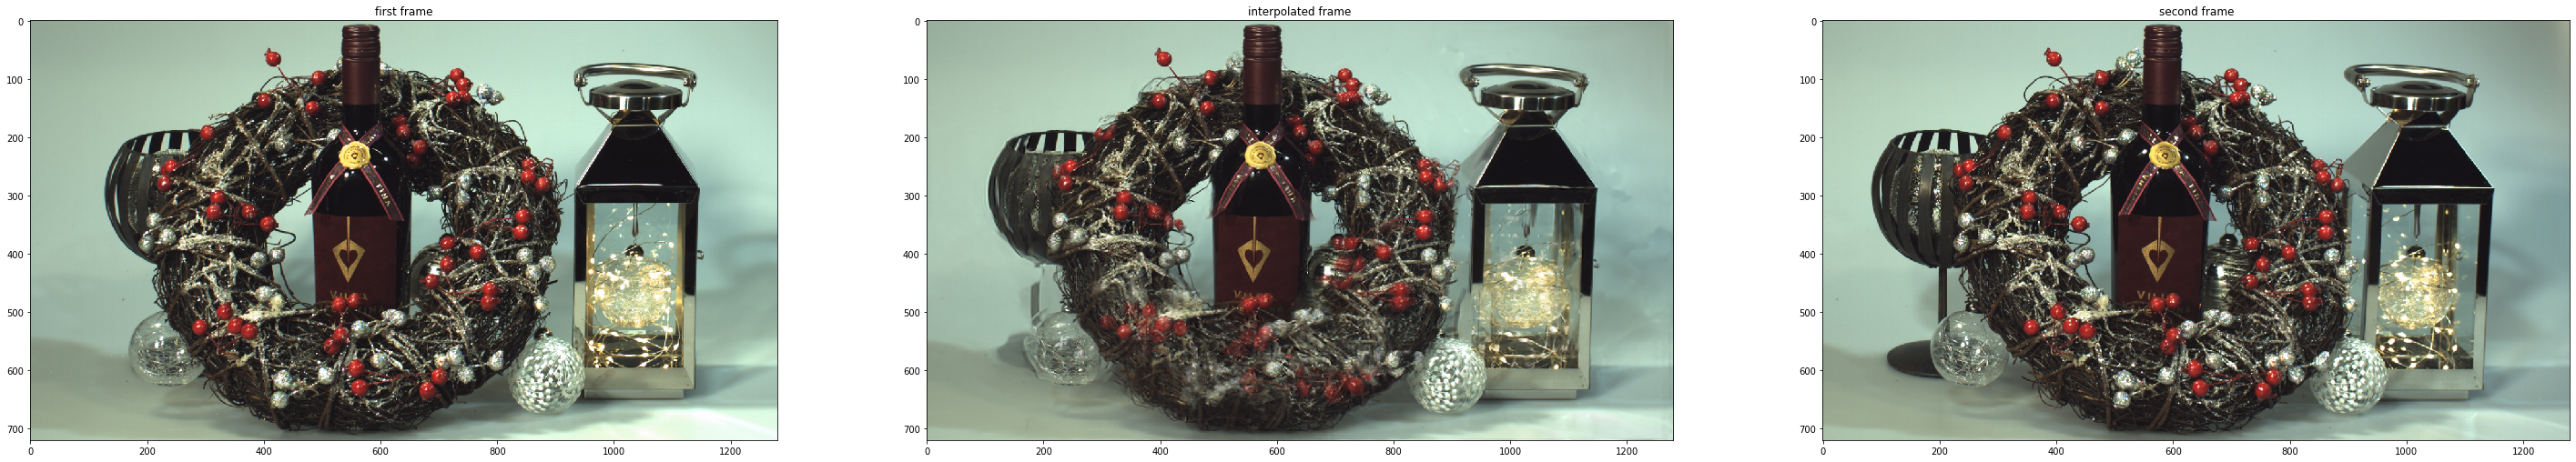

In [11]:
def plotResults(firstIm, interpolatedIm, secIm):
    fig = plt.figure(figsize=(50,20))
    plt.subplot(1,3,1); plt.imshow(firstIm); plt.gca().set_title('first frame')
    plt.subplot(1,3,2); plt.imshow(interpolatedIm); plt.gca().set_title('interpolated frame')
    plt.subplot(1,3,3); plt.imshow(secIm); plt.gca().set_title('second frame')

i = 1
plotResults(firstIms[i], interpolatedIms[i], secIms[i])

# Massive Testing

In [5]:
class massiveTest:
    def __init__(self, firstIm, secIm):
        self.myTransform = transforms.Compose([transforms.ToTensor()])
        self.firstImPath = firstIm
        self.secImPath = secIm
        self.firstIm = to_variable(self.myTransform(Image.open(firstIm)).unsqueeze(0))
        self.secIm = to_variable(self.myTransform(Image.open(secIm)).unsqueeze(0))
        
    def test(self, model, outputPath):
        print("Interpolating between {} and {}".format(self.firstImPath, self.secImPath))
        frame_out = model(self.firstIm, self.secIm)
        imwrite(frame_out, os.path.join(outputPath), range=(0, 1))
        print("----Done with output: {} ----".format(outputPath))
            
    def getFirstIms(self):
        return self.firstIms
    
    def getSecIms(self):
        return self.secIms

#### Input folders

In [6]:
castleInput = os.path.join(os.getcwd(), 'DSLF', 'Castle')
holidayInput = os.path.join(os.getcwd(), 'DSLF', 'Holiday')
sealBallsInput = os.path.join(os.getcwd(), 'DSLF', 'Seal&Balls')

#### Output folders

In [7]:
castleOutput = os.path.join(os.getcwd(), 'DSLF', 'CastleInterpolated')
holidayOutput = os.path.join(os.getcwd(), 'DSLF', 'HolidayInterpolated')
sealBallsOutput = os.path.join(os.getcwd(), 'DSLF', 'SealBallsInterpolated')

In [8]:
def to_variable(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

#### Castle Folder

In [10]:

if not os.path.exists(castleOutput):
    os.makedirs(castleOutput)

distance = 2
firstImNames = []
secImNames = []
outputNames = []

for folders, subfolders, files in os.walk(castleInput):
    if '.ipynb_checkpoints' not in folders:
        files[:] = [f for f in files if not f.startswith("_")]
        for file in sorted(files):
            name, extension = file.split('.')
            firstImNames.append(file)
            secImName = int(name) + distance
            secImNames.append("%04d" % secImName + "." + extension)
            ouputName = (int(name) + int(secImName)) / 2
            outputNames.append("%04d" % ouputName + "." + extension)
            if int(secImName) >= len(files):
                break
                
# print(len(firstImNames))
# print(len(secImNames))
# print(len(outputNames))

model = SepConvNet(kernel_size=args['kernel'])
model.eval()
model.to(torch.device("cuda"))

for idx, name in enumerate(firstImNames):
#     print(name, outputNames[idx], secImNames[idx])
    firstImPath = os.path.join(castleInput, name)
    secImPath = os.path.join(castleInput, secImNames[idx])
    outputImPath = os.path.join(castleOutput, outputNames[idx])
#     print(firstImPath, outputImPath, secImPath)
    massiveTest = massiveTest(firstImPath, secImPath)
    massiveTest.test(model, outputImPath)
    del massiveTest

Interpolating between C:\Users\nguyen29\Desktop\pytorch-sepconv\DSLF\Castle\0001.png and C:\Users\nguyen29\Desktop\pytorch-sepconv\DSLF\Castle\0003.png
----Done with output: C:\Users\nguyen29\Desktop\pytorch-sepconv\DSLF\CastleInterpolated\0002.png ----


NameError: name 'massiveTest' is not defined

In [17]:
massiveTeset = massiveTest('C:\Users\nguyen29\Desktop\pytorch-sepconv\DSLF\Castle\0001.png', 'C:\Users\nguyen29\Desktop\pytorch-sepconv\DSLF\Castle\0003.png')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-17-7cca54b08d80>, line 1)

# Experimenting

In [187]:
path1 = os.path.join(os.getcwd(), 'DSLF', 'Castle', '0001.png')
path2 = os.path.join(os.getcwd(), 'DSLF', 'Castle', '0002.png')

In [188]:
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [189]:
np.linalg.norm(load_image(path1) - load_image(path2))

7994.445696857288

In [17]:
massiveTest = massiveTest(firstImPath, secImPath)

In [18]:
if(massiveTest):
    print('ca')

ca
